In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GroupingAlgorithms import *
from functions_VQE_v2 import *
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.opflow import converters
from qiskit.algorithms.optimizers import SPSA
from qiskit.opflow.primitive_ops import Z2Symmetries
from IPython.display import display, clear_output

ModuleNotFoundError: No module named 'functions_VQE_v2'

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris)
NUM_SHOTS = 2**13  # Number of shots for each circuit

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PyQuanteDriver(molecule)
qmolecule = driver.run()
freezeCoreTransfomer = FreezeCoreTransformer( freeze_core=True, remove_orbitals= [3,4] )
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

qubit_op = converter.convert(main_op, num_particles=num_particles)

num_qubits = qubit_op.num_qubits
WC=list(range(num_qubits))
WC=list(permutations(list(range(num_qubits)),2))

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print( num_qubits )
print( qubit_op )

4
-0.20316612481217325 * IIII
+ (-0.365258527098598-1.3877787807814457e-17j) * ZIII
+ 0.09275974420404098 * IZII
- 0.2118902053549851 * ZZII
+ (0.365258527098598+2.7755575615628914e-17j) * IIZI
- 0.11384420116816225 * ZIZI
+ 0.11395335131674317 * IZZI
+ (-0.06043919280467715-3.469446951953614e-18j) * ZZZI
+ (-0.09275974420404105-3.469446951953614e-18j) * IIIZ
+ 0.11395335131674318 * ZIIZ
+ (-0.12274347556009738-6.938893903907228e-18j) * IZIZ
+ 0.056287757667526306 * ZZIZ
+ (-0.2118902053549851-6.938893903907228e-18j) * IIZZ
+ 0.06043919280467715 * ZIZZ
- 0.056287757667526306 * IZZZ
+ 0.0846016988633049 * ZZZZ
+ 0.019390023793252498 * XIII
+ (-0.019390023793252498+8.673617379884035e-19j) * XZII
- 0.010951534973539137 * XIZI
+ 0.010951534973539137 * XZZI
+ 0.01277809801936714 * XIIZ
- 0.01277809801936714 * XZIZ
- 0.00900252139905185 * XIZZ
+ 0.00900252139905185 * XZZZ
- 0.002936887226605865 * IXII
- 0.0029368872266058656 * ZXII
+ 0.010679892682752462 * IXZI
+ 0.010679892682752462 * ZXZI


In [4]:
init_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

In [5]:
paulis, coeff, label = Label2Chain(qubit_op)
print( 'number of Paulis:', len(coeff) )

Color, Groups_tpb, Measurements_tpb = TPBgrouping(paulis)
print( 'number of TPB groups:', len(Groups_tpb) )
Groups_tpb = [ [ idx2[0] for idx2 in idx1 ] for idx1 in Groups_tpb ]
Measurements_tpb = [ [ [idx[j][0],[j]] for j in range(num_qubits) ] for idx in Measurements_tpb ]

Groups_bell, Measurements_bell = grouping( paulis,[4,3,1,2],WC)
print('number of Bell groups:', len(Groups_bell) )

Groups_bell_paris, Measurements_bell_paris = grouping( paulis,[4,3,1,2],WC_paris)
print('number of Bell groups:', len(Groups_bell_paris) )

number of Paulis: 100
number of TPB groups: 25
number of Bell groups: 15


D:\Saco_CSIC\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\GroupingAlgorithms.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):


number of Bell groups: 9


In [6]:
# 0-1-2-3
#   |
#   4

In [7]:
Measurements_bell

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[4, [0, 2]], [4, [1, 3]]],
 [[4, [0, 3]], [4, [1, 2]]],
 [[3, [2]], [3, [3]], [3, [1]], [1, [0]]],
 [[3, [2]], [3, [3]], [3, [0]], [1, [1]]],
 [[3, [0]], [3, [1]], [3, [3]], [1, [2]]],
 [[3, [1]], [3, [3]], [1, [0]], [1, [2]]],
 [[3, [0]], [3, [3]], [1, [1]], [1, [2]]],
 [[3, [0]], [3, [1]], [3, [2]], [1, [3]]],
 [[3, [1]], [3, [2]], [1, [0]], [1, [3]]],
 [[3, [0]], [3, [2]], [1, [1]], [1, [3]]]]

In [8]:
Measurements_bell_paris

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[1, [2]], [1, [0]], [3, [3]], [3, [1]]],
 [[1, [2]], [1, [1]], [3, [3]], [3, [0]]],
 [[1, [3]], [1, [0]], [3, [2]], [3, [1]]],
 [[1, [3]], [1, [1]], [3, [2]], [3, [0]]]]

In [9]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)
entangled_layer

[(0, 1), (1, 2), (2, 3)]

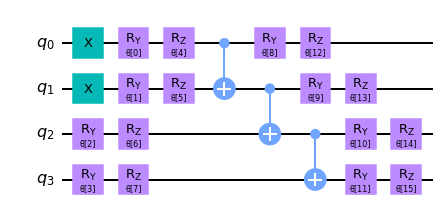

In [10]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

In [11]:
prob2Exp =  probability2expected( coeff, label, Groups_bell_paris, Measurements_bell_paris )
len(prob2Exp)

9

In [12]:
qc = []
n_measure = []
for measure in Measurements_bell_paris :
    qc_temp, n_measure_temp = measure_circuit_factor( measure , num_qubits )
    qc.append( qc_temp.compose(ansatz,front=True) )
    n_measure.append( n_measure_temp )

In [13]:
def Objective( pars, qc, callback=None, backend=AerSimulator(method="statevector") ) :
    
    qc = [ qci.assign_parameters(pars) for qci in qc ]
    t_qc = transpile(qc, backend)
    qc_obj = assemble(t_qc, shots=NUM_SHOTS)
    counts = backend.run(qc_obj).result().get_counts()
     
    probabilities = [ post_process_results(counts[j], n_measure[j], NUM_SHOTS) for j in range(len(counts))]
    
    ExpectedValues = 0
    for j in range(len(probabilities)) :
        ExpectedValues += np.sum( prob2Exp[j]@probabilities[j] )
        
    if callback is not None :
        callback( ExpectedValues, pars )
        
    return ExpectedValues    

In [14]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var
fun1 = lambda pars : Objective( pars, qc, backend=backend_noise )
fun2 = lambda pars : objective_function(pars, coeff, label, Groups_tpb, Measurements_tpb, ansatz, backend_sim, NUM_SHOTS)

In [15]:
fun1(pars)

-0.22211027701475572

In [16]:
fun2(pars)

-0.2129459369317149

In [17]:
Hamiltonian = qubit_op.to_matrix()
qc_state = ansatz.assign_parameters(pars)
qc_state.save_statevector()
state = backend_sim.run(qc_state).result().get_statevector()
np.vdot( state, Hamiltonian@state )

(-0.214956492657136+2.7755575615628914e-17j)

In [18]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc   = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887061050307454


In [19]:
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

fun = lambda pars : Objective( pars, qc , callback, backend_noise )

optimizer = SPSA( maxiter=300, last_avg=25 )

In [20]:
results = optimizer.optimize( num_var, fun, initial_point=pars )

'650, -1.0314680666144007'

In [21]:
results

(array([ 1.44349824e-01,  1.51342197e+00,  4.73330142e+00, -1.59273471e+00,
        -7.00476083e+00,  2.59816783e-03, -3.14334589e+00, -3.15638122e+00,
         1.60929778e-01,  4.66481252e+00, -1.57060167e+00, -1.57543874e+00,
         2.25935263e+00,  4.71125283e+00,  5.46801487e+00, -4.69586878e+00]),
 -1.0314680666144007,
 600)

In [22]:
len( evaluations )

651

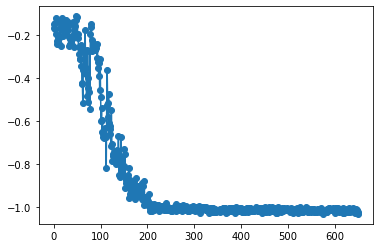

In [23]:
plt.plot(evaluations,'-o')

In [24]:
np.save( 'sim_noise_params_rep1', np.array(parameters) )
np.save( 'sim_noise_energy_rep1', np.array(evaluations) )

In [2]:
F = [-1.9933792581873249, -1.6550700937983223, -1.676321959962387, -1.9426267725701503, -1.517824451345494, -1.952561140151579, -1.494377267797823, -1.8820203014218233, -1.9077282248434408, -1.5445878075682757, -1.5481860346844882, -1.821284898180879, -1.8036872894428015, -1.5647862921706222, -1.274354720353787, -1.7316201670022666, -0.8788327182938768, -0.8995657814668836, -1.0375658981288467, -1.0250619866889386, -1.8656245561964995, -1.2904387360113052, -1.292706344290027, -0.8454567602539662, -0.6294123355792686, -1.3467951989517193, -1.9228968065276604, -1.4772654363347768, -1.084126377624762, -1.0015693612790324, -0.8315918984824449, -1.2080905711623164, -1.4877170470020005, -1.8250892437873651, -0.9353763104742613, -0.9636969742540176, -1.0165005462795413, -0.9684744068519145, -1.4385756978345805, -1.8972234621087574, -1.4105498822893983, -1.9552291010504819, -1.8067673089421543, -1.481753003583416, -1.2938129466089137, -0.699550772371212, -1.0952594651356449, -1.0583976194706763, -1.7793206943175512, -1.489883187787827, -1.4692283797690548, -1.784487039576422, -3.11329760259875, -2.3140889254676273, -3.6287509823318866, -3.162632004304565, -3.52037207417133, -3.8695360015021465, -3.256712746251054, -4.470246942146149, -3.0060373788244057, -3.2843040389567992, -2.965571191863911, -3.645856418069292, -4.180964118907917, -3.697163827337713, -4.5447862872099085, -3.5919219495624013, -4.165061586247675, -4.296126211942877, -4.3925264753691495, -4.1797310367614084, -3.9086604164345022, -4.502454128736257, -4.656436458148853, -3.9661040341097245, -4.107946431161961, -3.9848523338357404, -3.833902693281653, -4.462180973502574, -3.7773741140886012, -4.714208428733224, -3.96273782646118, -3.0598922433483478, -3.6381070360850196, -4.589548412954737, -4.138575666543778, -4.182989260313181, -4.581543014607178, -3.5837951756267254, -4.505320583537177, -5.0071327763478175, -4.642718065191729, -4.651445455083323, -4.318223235828724, -5.19576407783542, -4.62343449469968, -4.987248791822046, -4.719468963721089, -4.7195426857046385, -4.5968743204637175, -5.2164254169334825, -4.933597837977029, -5.3676779933721965, -5.746066887175846, -4.77359786964996, -5.35795718330889, -5.462969484830785, -5.237308757107121, -5.703102158626203, -5.148315043500316, -6.094202793850118, -5.670538068320766, -5.232713637215165, -5.395558378438022, -5.366555405287796, -5.227694839952869, -5.533397323564809, -5.118251960497883, -5.791249386778762, -5.782329982940055, -5.715321812384343, -6.067979521657034, -5.410229352265843, -5.7463813650092925, -6.0546499693160145, -6.311469505137478, -5.478096178521609, -6.328824130850367, -5.983866063374041, -5.988022593355597, -6.352407887242552, -5.923596224960655, -6.042533804855225, -5.596058566689651, -6.622558658188812, -6.255362247579349, -6.670829184825495, -6.516643462339682, -6.331004356044579, -6.830016288001502, -6.083565995957752, -6.558891638396563, -6.742918634107086, -6.447675835266706, -6.813582914678946, -6.748431004065757, -6.771355035319172, -6.906397317489539, -6.659152736502856, -6.680812611822234, -7.0019076700548935, -6.809907219442879, -7.008094670853922, -6.392869936939573, -7.036843412958079, -7.003931667616758, -6.468961009295699, -6.7626933577305115, -6.710862689709369, -6.336405859417667, -7.164796860427525, -7.019885207690296, -6.835411563801986, -6.864199136278763, -6.7739715118038495, -6.69193704065792, -6.866597812289904, -6.652388896901087, -7.1835162432154425, -6.856406295293679, -7.121690625768297, -7.092999034492004, -6.850827710397002, -7.175287716592138, -6.993308798538261, -7.06963189601329, -7.018666406663497, -7.061352240396198, -7.208444021577087, -7.0455323396790455, -7.031589156650982, -6.789245559681554, -7.181268643663977, -7.0701100783688915, -7.254016467700835, -6.997326338646344, -7.241680060964678, -6.966471344675132, -7.145767448746229, -7.293701109457636, -6.931038875229017, -7.189497882135789, -6.9920097432542905, -7.247779229299038, -6.991596834999514, -7.1223380146847, -7.0370374653621806, -7.243866154095605, -7.194749911755868, -7.212750708708178, -7.209130349046713, -7.2114509657571, -7.224690229754911, -7.1966800802033495, -7.040250822679546, -7.214012714855839, -7.199583970470244, -7.237368172804722, -7.074579310307138, -7.167219129441633, -7.344450832795903, -7.216890660532714, -7.240983449815417, -7.239799133597213, -6.98180220239748, -7.215464706666828, -7.217849503958443, -7.480955540508984, -6.957862833491332, -7.365658736156798, -7.221000911402168, -7.2878162194103195, -7.072478771569871, -7.391377736417728, -7.200543255534717, -7.377674620089888, -7.19775077504247, -7.2374173879592725, -7.549535942840725, -7.573830754451855, -7.245031169953695, -7.49786673398442, -7.264574839835168, -7.635459053920329, -7.2740467693248485, -7.3817504822806566, -7.53745614698374, -7.449144219262602, -7.595351615049595, -7.505962128608989, -7.51716452658607, -7.407032448414876, -7.355804983955566, -7.243083704366398, -7.367109220361064, -7.431680749885574, -7.378566435257588, -7.464086956019032, -7.3975245019467195, -7.352914796996826, -7.410515511791234, -7.466328462373319, -7.236960028833875, -7.3168379296296315, -7.315079034778285, -7.375026084342542, -7.524360944843881, -7.296517165041882, -7.319659720172725, -7.50620105114624, -7.499005426190598, -7.514820723379592, -7.282995646361661, -7.47447308767084, -7.373031461541417, -7.446565408504165, -7.367556985153253, -7.442829984441937, -7.544578138880618, -7.514980611589758, -7.599977354387478, -7.52221686647181, -7.582386073967334, -7.6221760628755915, -7.671719227194313, -7.687550950648108, -7.598214856966328, -7.466380694021991, -7.492296102605013, -7.5401703112335206, -7.6339859993847625, -7.648328531001729, -7.451541917447027, -7.757946430270573, -7.655946987235059, -7.616308057519479, -7.691401545753611, -7.666002676698699, -7.52767013128919, -7.5362325249344515, -7.712772362770771, -7.73912840058235, -7.536228918540985, -7.650928046333662, -7.7788825162667345, -7.604841396484032, -7.581983329889963, -7.671998574524922, -7.580295471236884, -7.574097341069146, -7.606560866653769, -7.583578050288212, -7.650733066447964, -7.681141076561817, -7.641591734833924, -7.567362106678014, -7.6535265871314575, -7.52676467784947, -7.586179938569869, -7.494848549036865, -7.623250649092266, -7.597940834520087, -7.577313697510577, -7.661797846563942, -7.635268444705707, -7.561350342203746, -7.58853103326157, -7.768583858341612, -7.576879141887241, -7.575076703912462, -7.616428115199027, -7.636587117948656, -7.571358116910493, -7.491116638418793, -7.683627189603271, -7.7118373444502595, -7.575866886586663, -7.627661690239592, -7.632051802040635, -7.758862463163134, -7.616760806976185, -7.6842380049661365, -7.6806945245389, -7.653133754373271, -7.668479422608128, -7.597163638336989, -7.763998705334547, -7.658647226833983, -7.627299046777108, -7.670663885333307, -7.693468409194459, -7.687342096777604, -7.721803269379686, -7.710762264213609, -7.664591198525417, -7.518817160854935, -7.5795505878189875, -7.7229819581026815, -7.7023386147199995, -7.769308288344124]

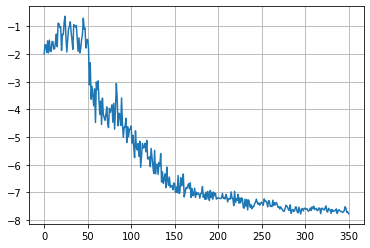

In [4]:
plt.plot(F)
plt.grid()